In [8]:
%matplotlib inline

import numpy  as np
import healpy as hp
import sys
#
from matplotlib_params_file import *

## load DESI data

In [9]:
def read_data(file_path):
    # Load data from the text file
    data = np.loadtxt(file_path)

    # Extract column names from the header
    with open(file_path, 'r') as file:
        header = file.readline().strip()
        column_names = header.split()

    # Create a dictionary to store data with column names
    data_dict = {}
    column_names = column_names[1:]
    for i, column_name in enumerate(column_names):
        data_dict[column_name] = data[:, i]

    return column_names, data_dict

In [10]:
version = 'v_0.8'
# Example usage:
file_path = f'/pscratch/sd/r/rmvd2/DESI/qsonic_contfit/iron/{version}/mean_delta_maps_cmbxlya/ra_dec_iron.txt'
column_names, data = read_data(file_path)
print(column_names)


['RA', 'Dec', 'Mean_Z', 'Mean_Z_Weighted', 'TID', 'Mean_Delta_W', 'Mean_Delta', 'Sum_Weight', 'num_pix']


In [11]:
ra = data['RA']
dec = data['Dec']
mean_z = data['Mean_Z']
mean_z_weight = data['Mean_Z_Weighted']
tid = data['TID']
Mean_Delta_W = data['Mean_Delta_W']
Mean_Delta = data['Mean_Delta']
Sum_Weight = data['Sum_Weight']
num_pix = data['num_pix']
mean_weight = Sum_Weight/num_pix
Mean_Delta_W_all = np.mean(Mean_Delta_W)

# subtract mean from the map
Mean_Delta_W -= Mean_Delta_W_all

# remove outliers from the map
delta_cut = 3
delta_mask = (Mean_Delta_W>-delta_cut) & (Mean_Delta_W<delta_cut)
print('removed', len(Mean_Delta_W)-np.sum(delta_mask), 'outliers')

removed 1789 outliers


In [12]:
# define for SHT 
wrand = mean_weight
wdata = Mean_Delta_W

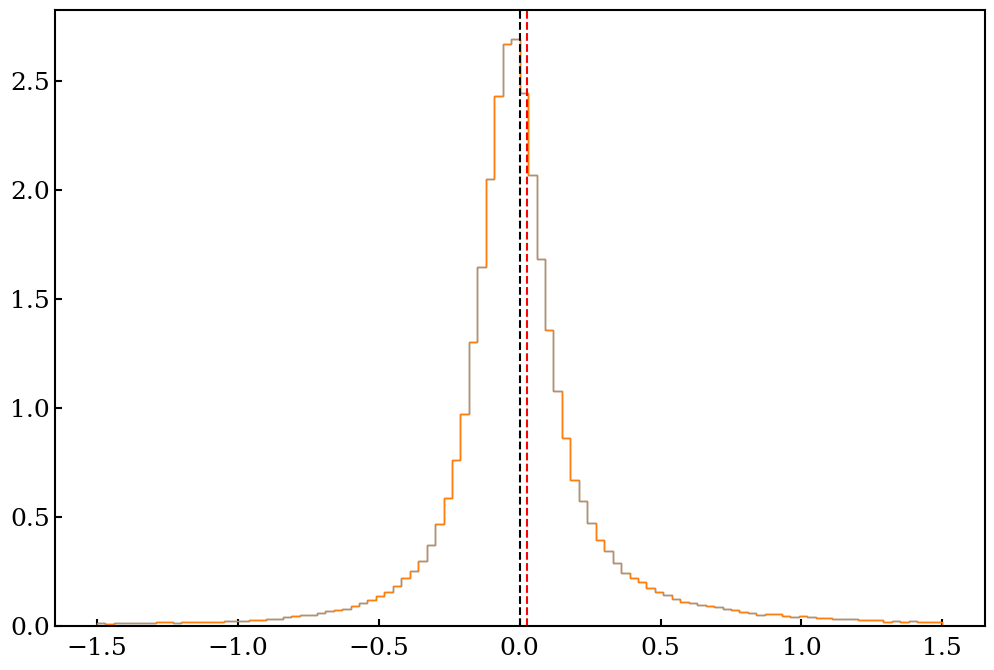

In [14]:
plt.hist(Mean_Delta_W, range=(-1.5, 1.5), bins=100, density=True, histtype='step');
plt.hist(Mean_Delta_W[delta_mask], range=(-1.5, 1.5), bins=100,density=True, histtype='step');
plt.axvline(0, color='k', linestyle='--')
plt.axvline(Mean_Delta_W_all, color='r', linestyle='--')


2.3746353217274967


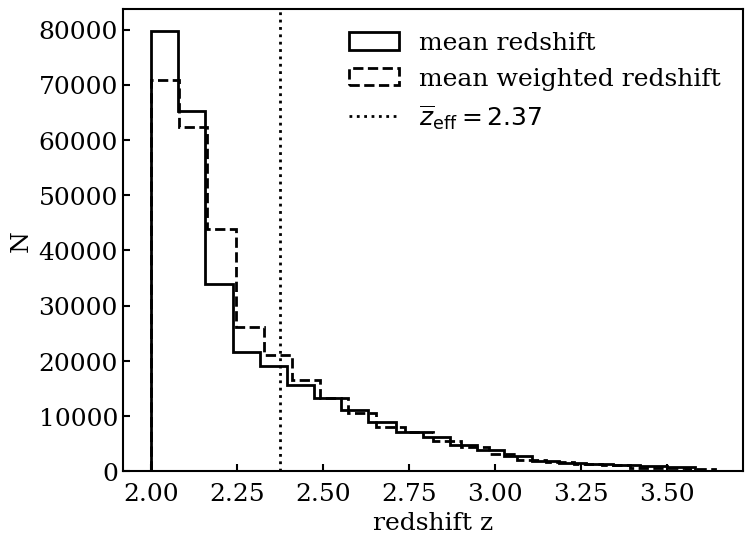

In [98]:
plt.figure(figsize=(8,6))
plt.hist(data['Mean_Z'], color='k',lw=2,  bins=20, histtype='step', label=r'mean redshift');
plt.hist(data['Mean_Z_Weighted'],color='k',lw=2, ls='--',  bins=20, histtype='step', label=r'mean weighted redshift');
plt.axvline(np.average(data['Mean_Z_Weighted'], weights=data['Sum_Weight']), color='k',lw=2, ls=':', label=r'$\overline{z}_{\mathrm{eff}}=2.37$')
plt.legend()
plt.xlabel('redshift z')
plt.ylabel('N')
plt.savefig('./plots/mean_z_all.pdf', bbox_inches='tight')
print(np.average(data['Mean_Z_Weighted'], weights=data['Sum_Weight']))

2.3746353217274967

### convert to galactic coordinates

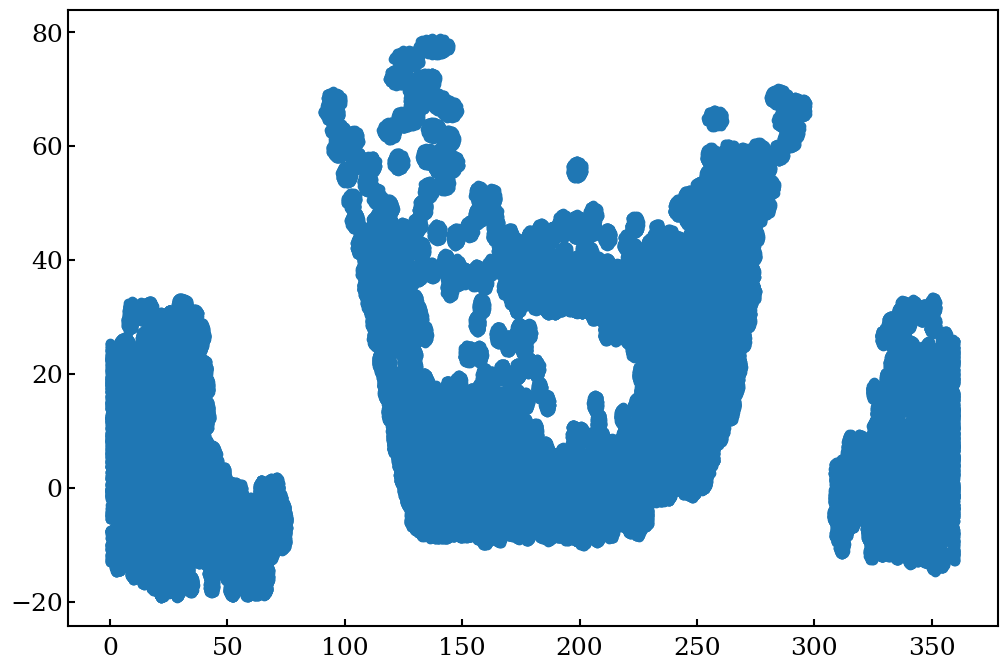

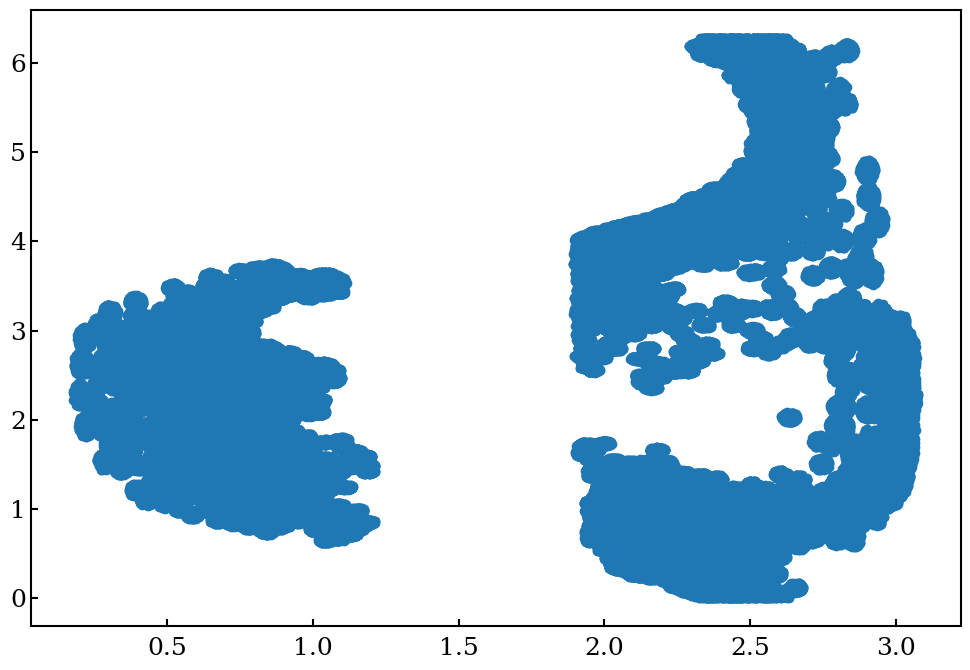

In [15]:
from astropy.coordinates import SkyCoord
import astropy.units as u

plt.scatter(data['RA'], data['Dec']);plt.show()

# Create SkyCoord object with RA and Dec data in degrees
c_icrs = SkyCoord(data['RA']* u.deg, data['Dec']* u.deg, frame='icrs')

# Transform coordinates to Galactic frame
c_galactic = c_icrs.transform_to('galactic')

# Extract theta and phi angles in radians
tdata_rad = c_galactic.spherical.lat  # Galactic  in radians
pdata_rad = c_galactic.spherical.lon    # Galactic  in radians

tdata = tdata_rad.to(u.rad).value+np.pi/2.
pdata = pdata_rad.to(u.rad).value

plt.scatter(tdata, pdata);plt.show()


In [16]:

def make_healpix_density_map(ra, dec, nside, weights=None, save_map=False, save_name=None, do_plot=False, title=None):
    """
    takes in a catalogue and makes healpix map
    """
    nside_lr = 16
    pixels = hp.ang2pix(nside, theta=ra, phi=dec, lonlat=True)
    pixels_lr = hp.ang2pix(nside_lr, theta=ra, phi=dec, lonlat=True)
    if weights is not None:
        fmap = np.bincount(pixels, weights=weights, minlength=hp.nside2npix(nside))
        fmap_lr = np.bincount(pixels_lr, weights=weights, minlength=hp.nside2npix(nside_lr))
    else:
        fmap = np.bincount(pixels, minlength=hp.nside2npix(nside))
        fmap_lr = np.bincount(pixels_lr, minlength=hp.nside2npix(nside_lr))

    if save_name is not None and save_map:
        hp.write_map(save_name, fmap, overwrite=True)
    if do_plot:
        # Mask pixels that are zero in grey
        mask = fmap_lr == 0
        fmap_lr[mask] = np.nan
        hp.mollview(fmap_lr, title='%s (Nside=16)'%title);plt.show()
    return fmap

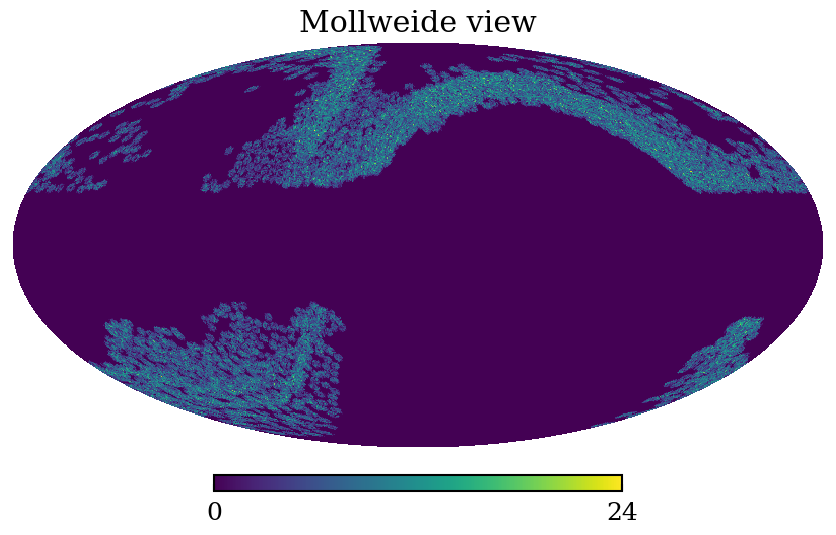

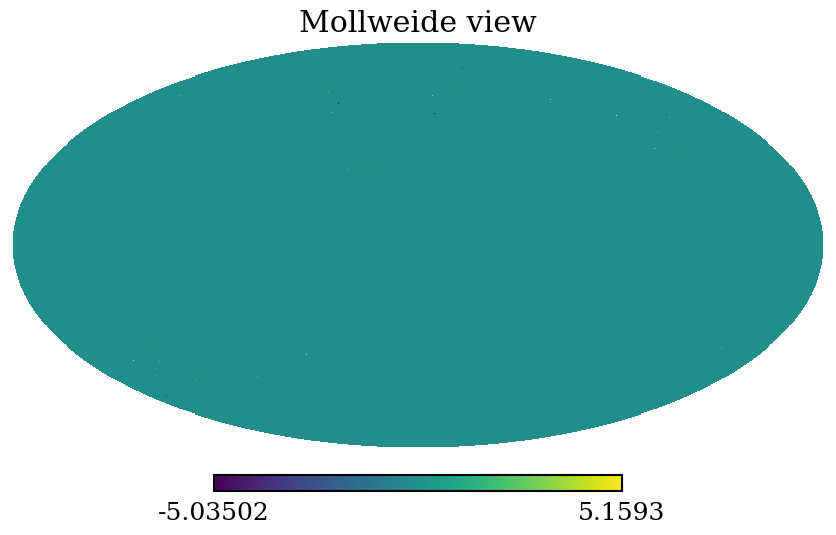

In [60]:
lya_map = make_healpix_density_map(c_galactic.l.value, c_galactic.b.value, nside=128, weights=None, save_map=False, save_name=None, do_plot=False, title=None)
hp.mollview(lya_map);plt.show() #, title='Lya counts (Nside=512)'
mm = make_healpix_density_map(c_galactic.l.value, c_galactic.b.value, nside=2048, weights=Mean_Delta_W, save_map=False, save_name=None, do_plot=False, title=None)
hp.mollview(mm);plt.show() # , title='Lya weighted density (sum w*delta /sum w) (Nside=512)'
#hp.write_map('/pscratch/sd/r/rmvd2/CMBxLya/data/lya_mean_delta_weights.fits', mm)

## load Planck maps 

In [61]:
def unmask(x, mask):
    y=np.zeros(len(mask))
    y[mask==1] = x
    return y

In [62]:
# NPIPE
fcmb = '/global/cfs/cdirs/cmb/data/planck2020/PR4_lensing/PR4_klm_dat_p.fits'
fmask = '/global/cfs/cdirs/cmb/data/planck2020/PR4_lensing/mask.fits.gz'

# Planck PR3
fcmb  = '/pscratch/sd/r/rmvd2/CMBxLya/data/COM_Lensing_4096_R3.00/MV/dat_klm.fits'
fmask = '/pscratch/sd/r/rmvd2/CMBxLya/data/COM_Lensing_4096_R3.00/mask.fits.gz'

NSIDE=128

cmb_alm = hp.read_alm(fcmb)
cmb_map = hp.alm2map(cmb_alm, nside=NSIDE)

cmb_mask = hp.read_map(fmask)
cmb_mask = hp.ud_grade(cmb_mask, nside_out=NSIDE)


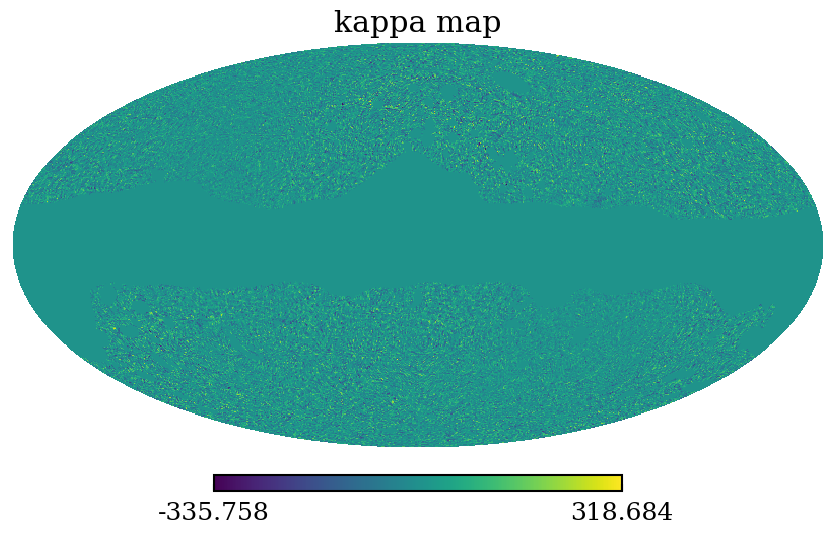

In [63]:
hp.mollview(unmask(cmb_map[np.floor(cmb_mask)==1], cmb_mask), title='kappa map')

## joint mask 

In [64]:
def cal_kq_mask(q_mask, cmb_mask, smooth_kernel=10): # calculate the shared masked region for the two maps

    smooth_q_mask = hp.sphtfunc.smoothing(q_mask,fwhm=np.deg2rad(smooth_kernel/60))
    smooth_cmb_mask = hp.sphtfunc.smoothing(cmb_mask,fwhm=np.deg2rad(smooth_kernel/60))                                    

    mask = smooth_cmb_mask*smooth_q_mask
    #mask = hp.sphtfunc.smoothing(self.q_mask*self.cmb_mask,fwhm=np.deg2rad(10/60))
    #mask = self.q_mask*self.cmb_mask 

    kq_mask = mask  
    return kq_mask


In [65]:
q_mask = lya_map>0
kq_mask = cal_kq_mask(q_mask, cmb_mask)

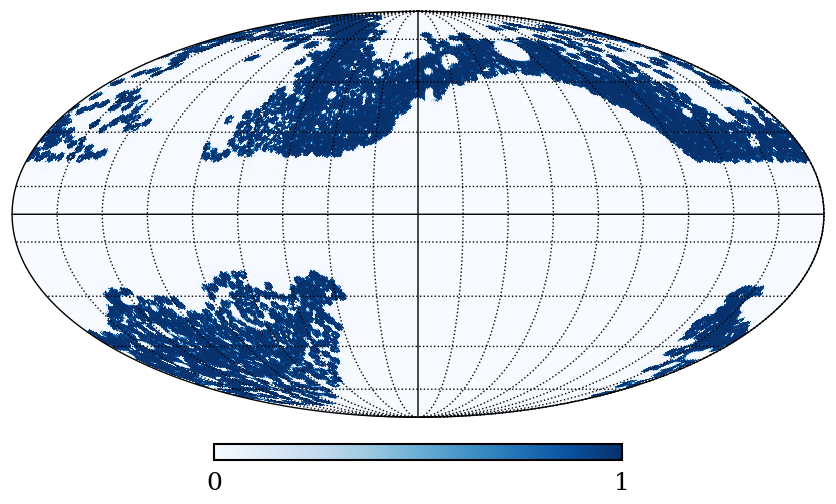

In [70]:
hp.mollview(kq_mask, min=0, max=1, cmap='Blues', title='')
hp.graticule(True);
plt.savefig('./plots/joint_mask_CMB_Lya.pdf', bbox_inches='tight')
#plt.title('joint mask Lya and CMB ')
plt.show()

In [77]:
(kq_mask>0.5).sum()/(kq_mask.size)

0.2309417724609375

In [104]:
plt.close()